In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import style
import random
import numpy.linalg as la
import scipy.io.wavfile
from scipy.signal import stft

In [4]:
def pca(centeredData, numOfComponents):
    [U,s,Vt] = la.svd(centeredData)
    Uk = U[:,:numOfComponents]
    sk = s[:numOfComponents]
    Wp = np.diag(sk**-0.5) @ Uk.T
    return Wp

In [5]:
class GaussianDiscriminant:
    def __init__(self, rawClassData, classProbability):
        self._rawClassData = rawClassData
        self.classMean = np.mean(rawClassData, axis=1).reshape((36,1))
        self.classCovariance = np.cov(rawClassData)
        self.classProbability = classProbability
        self.inverseClassCovariance = np.linalg.inv(self.classCovariance)
        self.getDiscriminantParameters()
        
    def getDiscriminantParameters(self):
        self.A = (-0.5) * self.inverseClassCovariance
        self.b = self.inverseClassCovariance @ self.classMean
        self.c = (-0.5) * (self.classMean.T @ self.inverseClassCovariance @ self.classMean + np.log(np.linalg.det(self.classCovariance))) + np.log(self.classProbability)
        
    def evalGaussianDiscriminantForMany(self, X):
        return np.sum((X.T @ self.A) * X.T, axis=1) + self.b.T @ X + self.c
    
class GausianClassifier:
    def __init__(self, rawData):
        self.gaussian_discriminant_functions = {}
        for i in range(numClasses):
            rawClassIndex = np.squeeze(np.argwhere(trainingY==i))
            rawClassData = rawData[:,rawClassIndex]
            self.gaussian_discriminant_functions[i] = GaussianDiscriminant(rawClassData, 100/1000)

In [6]:
# Load the files
number_music_files = 60
number_sound_files = 60
window_size = 256
sample_rate = 22050

music = []
speech = []
for i in range(number_music_files):
    sampleRate, data = scipy.io.wavfile.read(f'./Data/SpeechMusic/music/{i+1}.wav')
    music.append(data)
for i in range(number_sound_files):
    sampleRate, data = scipy.io.wavfile.read(f'./Data/SpeechMusic/speech/{i+1}.wav')
    speech.append(data)

music = np.hstack(music)
speech = np.hstack(speech)
np.shape(music)

(19845000,)

In [7]:
num_samples_music = np.size(music)
time_music = num_samples_music / sample_rate

num_samples_speech = np.size(music)
time_speech = num_samples_speech / sample_rate

print(f"We have {num_samples_music} samples for music for a total of {time_music} seconds.")
print(f"We have {num_samples_speech} samples for music for a total of {time_speech} seconds.")

We have 19845000 samples for music for a total of 900.0 seconds.
We have 19845000 samples for music for a total of 900.0 seconds.


In [8]:
# STFT

f_music, t_music, Zxx_music = stft(music, sample_rate, nperseg=window_size)
f_speech, t_speech, Zxx_speech = stft(speech, sample_rate, nperseg=window_size)

Zxx_music = np.log(np.abs(Zxx_music))
Zxx_speech = np.log(np.abs(Zxx_speech))

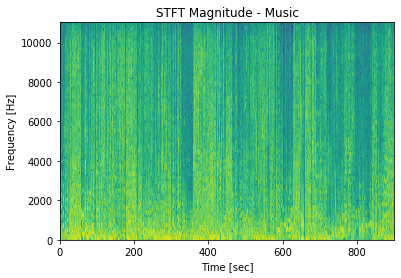

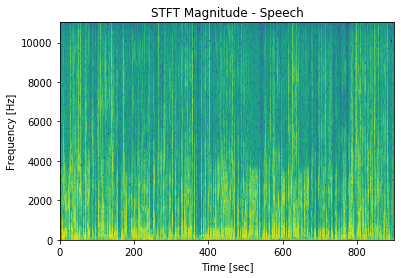

In [9]:
# Plot spectograms

plt.pcolormesh(t_music, f_music, Zxx_music)
plt.title('STFT Magnitude - Music')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

plt.pcolormesh(t_speech, f_speech, Zxx_speech)
plt.title('STFT Magnitude - Speech')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [10]:
# dat prep

data_labels = {0: "music", 1: "speech"}

training = []
testing = []
Zxx_music_with_labels = np.vstack([Zxx_music, np.zeros(np.shape(Zxx_music)[1])])
Zxx_speech_with_labels = np.vstack([Zxx_speech, np.ones(np.shape(Zxx_speech)[1])])
dataSet = np.hstack([Zxx_music_with_labels, Zxx_speech_with_labels])

numClasses = 2

for i in range(numClasses):
    labels = dataSet[129, :]

    classi =  dataSet[:,np.squeeze(np.argwhere(labels==i))]
    sizeClassi = np.shape(classi)[1]
    print(sizeClassi)
    randomSet = random.sample(range(sizeClassi), int(0.1*sizeClassi))
    conditionals1 = np.full(sizeClassi, False)
    conditionals1[randomSet] = True
    training.append(classi[:,~conditionals1])
    testing.append(classi[:,conditionals1])

training = np.hstack(training)
testing = np.hstack(testing)

trainingX = training[:129, :]
trainingY = training[129, :]
testingX = testing[:129, :]
testingY = testing[129, :]

print(np.shape(trainingX))
print(np.shape(trainingY))

print(np.shape(testingX))
print(np.shape(testingY))

155041
155041
(129, 279074)
(279074,)
(129, 31008)
(31008,)


In [11]:
# calculate the mean image and center all the training data
meanTrainingImage = np.mean(trainingX, axis = 1).reshape(-1, 1)

centeredTrainingX = trainingX - meanTrainingImage

print(np.shape(centeredTrainingX))

(129, 279074)


In [12]:
# run PCA on centered training data covariance to get Wp
centeredCovariance = np.cov(centeredTrainingX)
k=36
Wp = pca(centeredCovariance, k)
compressedTrainingX = Wp @ centeredTrainingX
compressedTestingX = Wp @ (testingX - meanTrainingImage)
Wp_inv = np.linalg.pinv(Wp)
print(np.shape(compressedTestingX))

(36, 31008)


In [13]:
# fit gaus
speech_music_classifier = GausianClassifier(compressedTrainingX)
scores = []
for i in range(numClasses):
    scores.append(speech_music_classifier.gaussian_discriminant_functions[i].evalGaussianDiscriminantForMany(compressedTestingX))
scores = np.squeeze(scores)
print(np.shape(scores))

(2, 31008)


In [14]:
# evaluate model 

numCorrect = 0
for i in range(31008):
    if(np.argmax(scores[:,i]) == int(testingY[i])):
        numCorrect += 1
print(numCorrect/31008)

0.9163764189886481


In [17]:
#sample_rate_music1, data_music1 = scipy.io.wavfile.read(f'./Data/SpeechMusic/music/{1}.wav')

In [21]:
# num_samples_music1 = data_music1.size
# time_music1 = num_samples_music1/sample_rate_music1
# print(num_samples_music1)
# print(time_music1)

330750
15.0
